In [1]:
# pip install scikit-image

In [2]:
import pickle
import main
import main_comp

%load_ext autoreload
%autoreload 1
%aimport main
%aimport main_comp

In [3]:
def save_logs(directory, logs):
    for log_name, log in logs.items():
        with open(directory + log_name, 'wb') as f:
            f.write(pickle.dumps(log))

In [4]:
def time_memory_consumption(data, path):
    with open(path, 'a') as f:
        f.write(data)

# Original NN

In [5]:
from models.skip import skip

In [6]:
input_depth = 32
n_channels = 3
skip_n33d = 128
skip_n33u = 128
skip_n11 = 4
num_scales = 5
upsample_mode = 'bilinear'
downsample_mode = 'stride'
pad = 'reflection'
act_fun = 'LeakyReLU'

In [7]:
net = skip(
    input_depth, 
    n_channels,
    num_channels_down=[skip_n33d] * num_scales,
    num_channels_up=[skip_n33u] * num_scales,
    num_channels_skip=[skip_n11] * num_scales,
    upsample_mode=upsample_mode, 
    downsample_mode=downsample_mode,
    need_sigmoid=True, 
    need_bias=True,
    pad=pad, 
    act_fun=act_fun
)
net

Sequential(
  (1): Concat(
    (0): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
      (7): Sequential(
        (1): Concat(
          (0): Sequential(
  

In [8]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

In [9]:
device = 'cuda'

In [10]:
N_ITERS = 3

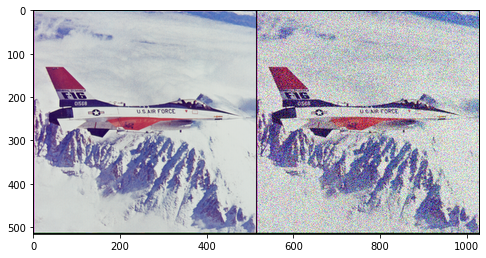

Number of params: 2217831
Starting optimization with ADAM


/home/Skoltech_MSc/TDTN/final_project/denoising_compression/main_comp.py:109: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_noisy = compare_ssim(img_noisy_np.T, out.detach().cpu().numpy()[0].T, multichannel=True)
/home/Skoltech_MSc/TDTN/final_project/denoising_compression/main_comp.py:110: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_gt = compare_ssim(img_np.T, out.detach().cpu().numpy()[0].T, multichannel=True)


Iteration 00000  Loss 0.085597  PSNR_noisy: 10.675431  PSNR_gt: 12.072019  PSNR_gt_sm: 12.072019  SSIM_noisy: 0.092076  SSIM_gt: 0.545173


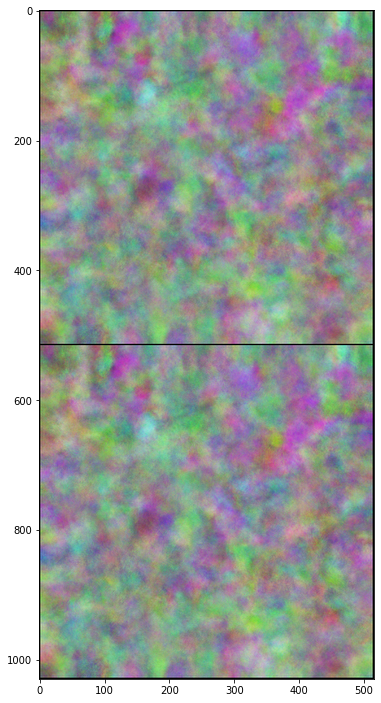

Iteration 00001  Loss 0.082399  PSNR_noisy: 10.840804  PSNR_gt: 12.447269  PSNR_gt_sm: 12.099829  SSIM_noisy: 0.094521  SSIM_gt: 0.612490
Iteration 00002  Loss 0.067448  PSNR_noisy: 11.710297  PSNR_gt: 13.987144  PSNR_gt_sm: 12.150432  SSIM_noisy: 0.097874  SSIM_gt: 0.686316


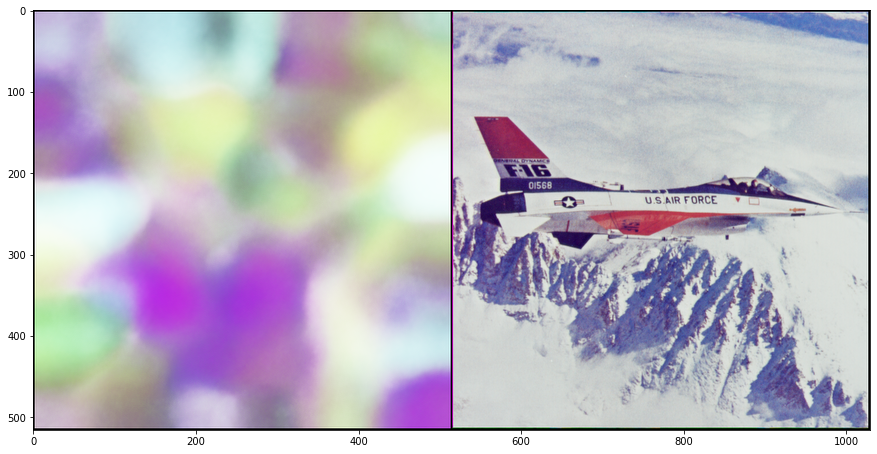

In [11]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
    profile_memory=True, 
    record_shapes=True
) as prof:
    with record_function("model_performance"):
        losses, psnrs_noisy, psnrs_gt, ssims_noisy, ssims_gt = main_comp.main_func(net, plot=True, num_iters=N_ITERS, device=device)
time_memory_consumption(prof.key_averages().table(), './logs/original_net.txt')

In [12]:
save_logs(
    './logs/', 
    {
        'losses': losses, 
        'psnrs_noisy': psnrs_noisy, 
        'psnrs_gt': psnrs_gt, 
        'ssims_noisy': ssims_noisy, 
        'ssims_gt': ssims_gt
    }
)

# Compressed NN

In [13]:
def get_layer_by_name(model, mname):
    '''
    Extract layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list:
        module = module._modules[mname]

    return module


def replace_conv_layer_by_name(model, mname, new_layer):
    '''
    Replace layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list[:-1]:
        module = module._modules[mname]
    module._modules[mname_list[-1]] = new_layer

In [14]:
def calculate_layer_cr(model_stats, lnames_to_compress, cr=2):
    '''
    When we compres whole model with compression ratio `cr`,
    we need to calculate layer compression ratio for each layer
    from `lnames_to_compress`. We apply the same compression rate
    to all layers.
    
    Returns: float
        layer compression ratio
        '''

    flops_to_compress = 0
    for lname in lnames_to_compress:
        flops_to_compress += model_stats.flops[lname][0]
    uncompressed_flops = model_stats.total_flops - flops_to_compress
    layer_cr = flops_to_compress * cr / (flops_to_compress + uncompressed_flops * (1- cr))
    return layer_cr

In [15]:
from copy import deepcopy

In [16]:
# pip install musco-pytorch, flopco-pytorch

In [17]:
from musco.pytorch import CompressorVBMF, CompressorPR, CompressorManual

In [18]:
import flopco
from flopco import FlopCo

In [31]:
def get_compressed_model(model, conv2d_nn_decomposition, model_compression_ratio=2, device='cpu'):
    model.to(device)
    model_stats = FlopCo(model, img_size=(1, 32, 512, 512), device=device)
    lnames = list(model_stats.flops.keys())
    lnames_to_compress = [
        lname for lname, layer in model.named_modules() 
        if str(layer).startswith('Conv2d') and '0' not in lname and '6' not in lname and '9' not in lname
    ]
    print(len(lnames_to_compress))

    layer_cr = calculate_layer_cr(model_stats, lnames_to_compress, cr=model_compression_ratio)

    param_reduction_rates = {lname: layer_cr for lname in lnames_to_compress}

    ### Implement CompressorPR class here

    compressor = CompressorPR(model,
                              model_stats,
                              conv2d_nn_decomposition=conv2d_nn_decomposition,
                              ft_every=len(lnames_to_compress), 
                              param_reduction_rates=param_reduction_rates,
                              nglobal_compress_iters=1)

    ### 
    compressor.lnames = lnames_to_compress
    
    compressor.compression_step()

    return compressor.compressed_model

15
1.1.1.1 tucker2
1.1.4.1 tucker2
1.1.7.1.1.1.1 tucker2
1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.3.1 tucker2
1.1.7.1.1.7.1.1.7.3.1 tucker2
1.1.7.1.1.7.3.1 tucker2
1.1.7.3.1 tucker2
3.1 tucker2


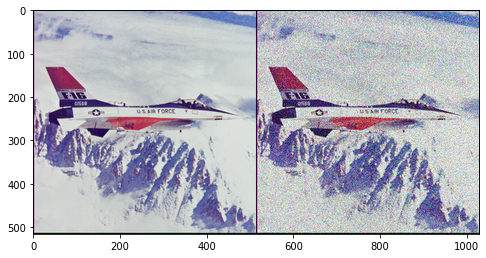

Number of params: 135695
Starting optimization with ADAM
Iteration 00000  Loss 0.082376  PSNR_noisy: 10.841993  PSNR_gt: 12.643318  PSNR_gt_sm: 12.643318  SSIM_noisy: 0.096625  SSIM_gt: 0.690940


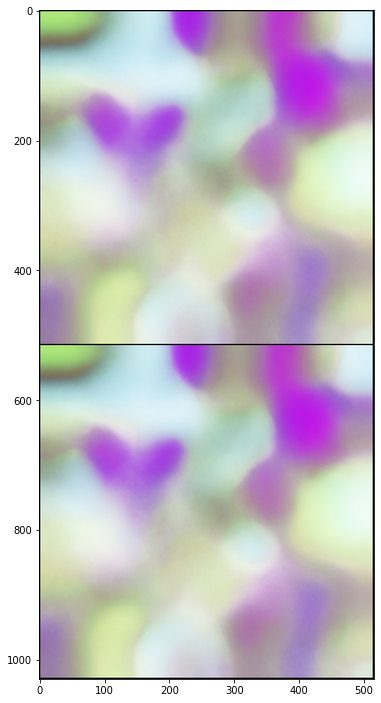

Iteration 00001  Loss 0.067518  PSNR_noisy: 11.705828  PSNR_gt: 14.021276  PSNR_gt_sm: 12.680865  SSIM_noisy: 0.098018  SSIM_gt: 0.697030
Iteration 00002  Loss 0.066818  PSNR_noisy: 11.751086  PSNR_gt: 14.014016  PSNR_gt_sm: 12.718703  SSIM_noisy: 0.098270  SSIM_gt: 0.707700


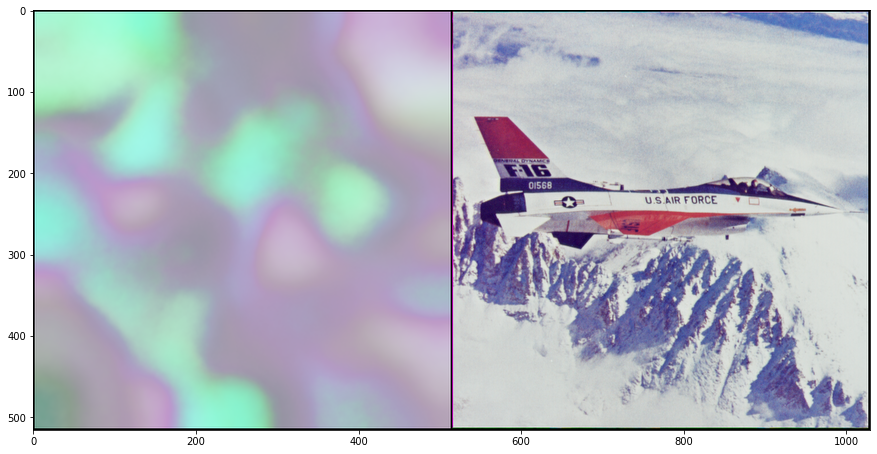

15
1.1.1.1 tucker2
1.1.4.1 tucker2
1.1.7.1.1.1.1 tucker2
1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.3.1 tucker2
1.1.7.1.1.7.1.1.7.3.1 tucker2
1.1.7.1.1.7.3.1 tucker2
1.1.7.3.1 tucker2
3.1 tucker2


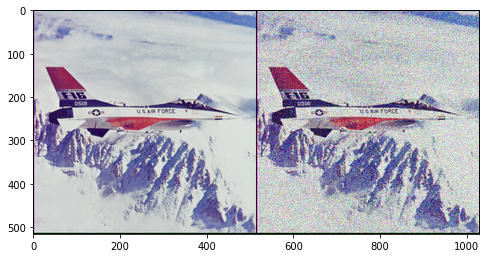

Number of params: 135695
Starting optimization with ADAM
Iteration 00000  Loss 0.077827  PSNR_noisy: 11.088704  PSNR_gt: 13.032477  PSNR_gt_sm: 13.032477  SSIM_noisy: 0.097184  SSIM_gt: 0.695621


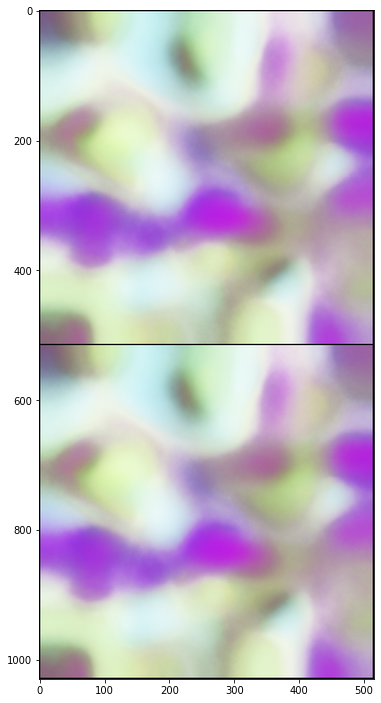

Iteration 00001  Loss 0.077135  PSNR_noisy: 11.127464  PSNR_gt: 12.987794  PSNR_gt_sm: 13.080570  SSIM_noisy: 0.096916  SSIM_gt: 0.685479
Iteration 00002  Loss 0.069748  PSNR_noisy: 11.564660  PSNR_gt: 13.659428  PSNR_gt_sm: 13.119196  SSIM_noisy: 0.097925  SSIM_gt: 0.705584


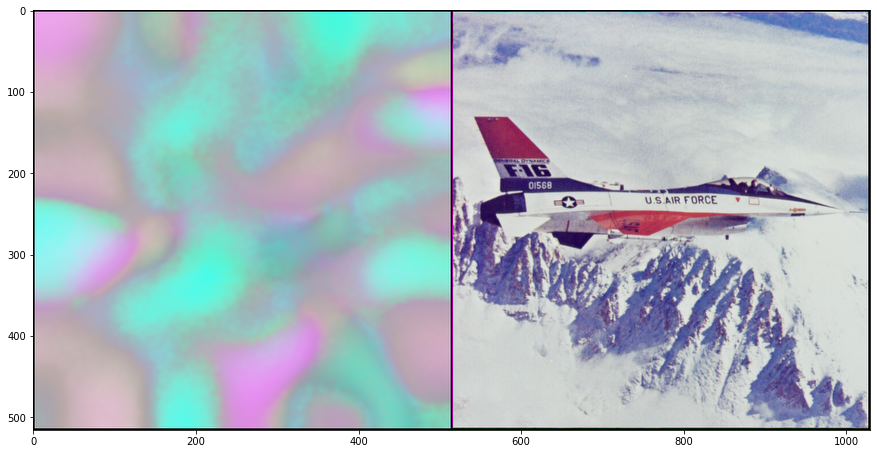

In [47]:
COMPRESSION_RATIO = [14, 15]
MODES = ['tucker2'] #, 'cp3']
N_ITERS = 3
ans_losses, ans_psnrs_noisy, ans_psnrs_gt, ans_ssims_noisy, ans_ssims_gt = dict(), dict(), dict(), dict(), dict()

for comp_ratio in COMPRESSION_RATIO:
    ans_losses[comp_ratio] = dict()
    ans_psnrs_noisy[comp_ratio], ans_psnrs_gt[comp_ratio] = dict(), dict()
    ans_ssims_noisy[comp_ratio], ans_ssims_gt[comp_ratio] = dict(), dict()
    
    for mode in MODES:
        compressed_model = get_compressed_model(net, conv2d_nn_decomposition=mode, model_compression_ratio=comp_ratio) 
        compressed_model.to(device)

        with profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
            profile_memory=True, 
            record_shapes=True
        ) as prof:   
            with record_function("model_performance"):
                losses_comp, psnrs_noisy_comp, psnrs_gt_comp, ssims_noisy_comp, ssims_gt_comp = main_comp.main_func(
                    compressed_model, plot=True, num_iters=N_ITERS, device=device
                )
        time_memory_consumption(prof.key_averages().table(), './logs/compressed_conv2d_mode_{}_comp_ratio_{}.txt'.format(mode, comp_ratio))
        ans_losses[comp_ratio][mode] = losses_comp
        ans_psnrs_noisy[comp_ratio][mode] = psnrs_noisy_comp
        ans_psnrs_gt[comp_ratio][mode] = psnrs_gt_comp
        ans_ssims_noisy[comp_ratio][mode] = ssims_noisy_comp
        ans_ssims_gt[comp_ratio][mode] = ssims_gt_comp
        
        save_logs(
            './logs/', 
            {
                'losses_mode_{}_comp_ratio_{}'.format(mode, comp_ratio): losses_comp, 
                'psnrs_noisy_mode_{}_comp_ratio_{}'.format(mode, comp_ratio): psnrs_noisy_comp, 
                'psnrs_gt_mode_{}_comp_ratio_{}'.format(mode, comp_ratio): psnrs_gt_comp, 
                'ssims_noisy_mode_{}_comp_ratio_{}'.format(mode, comp_ratio): ssims_noisy_comp, 
                'ssims_gt_mode_{}_comp_ratio_{}'.format(mode, comp_ratio): ssims_gt_comp
            }
        )
        
        torch.cuda.empty_cache()

In [48]:
import matplotlib.pyplot as plt

In [74]:
def plot_logs(ans_dict, logs_type, original):
    for comp_ratio, mode_logs in ans_dict.items():
        plt.figure(figsize=(10, 8))
        plt.title('{}; compression ratio = {}'.format(logs_type, comp_ratio), fontsize=18)
        for mode, logs in mode_logs.items():
            plt.plot(logs, label=mode)
        plt.plot(original, label='original')
        plt.legend(fontsize=16)
        plt.show()

In [75]:
ans_losses

{14: {'tucker2': [0.08237601071596146,
   0.06751762330532074,
   0.06681768596172333],
  'cp4': [1.0823760107159615, 1.0675176233053207, 1.0668176859617233]},
 15: {'tucker2': [0.07782687991857529,
   0.07713538408279419,
   0.06974835693836212],
  'cp4': [0.4778268799185753, 0.4771353840827942, 0.46974835693836214]}}

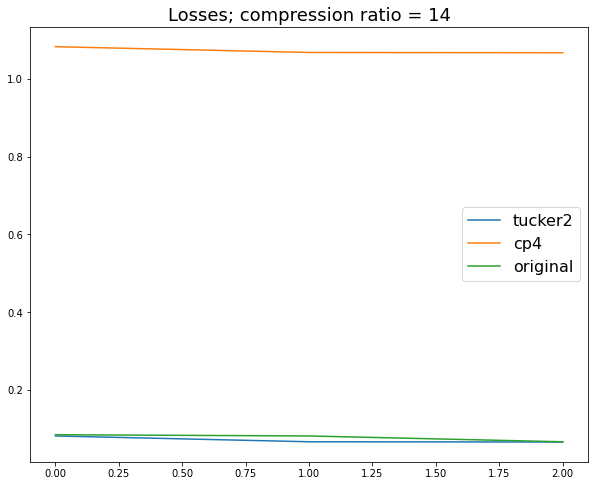

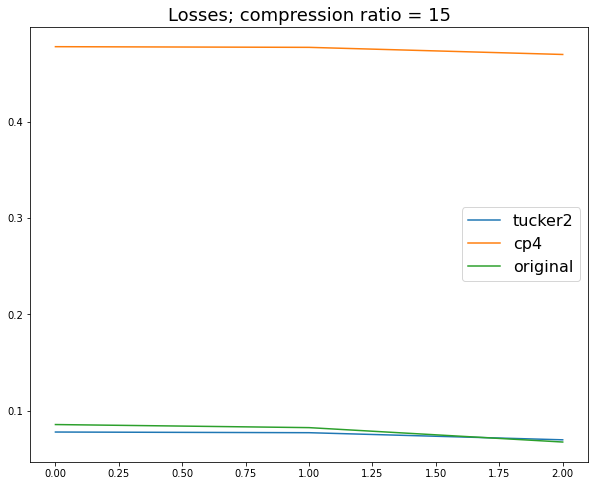

In [76]:
plot_logs(ans_losses, 'Losses', losses)

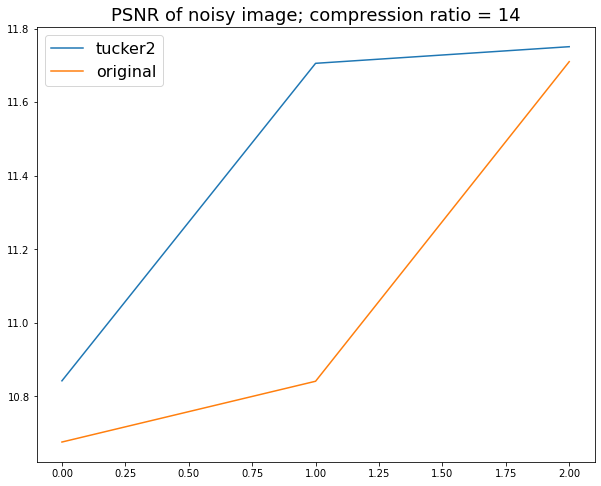

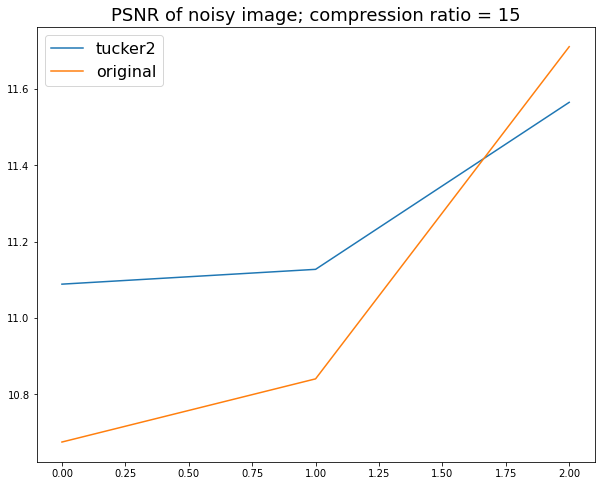

In [78]:
plot_logs(ans_psnrs_noisy, 'PSNR of noisy image', psnrs_noisy)

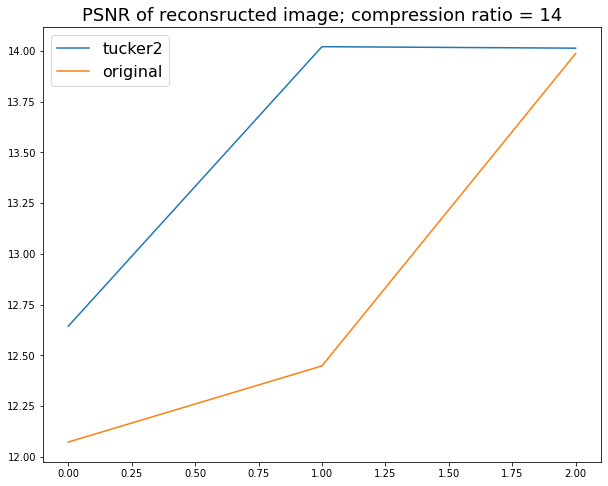

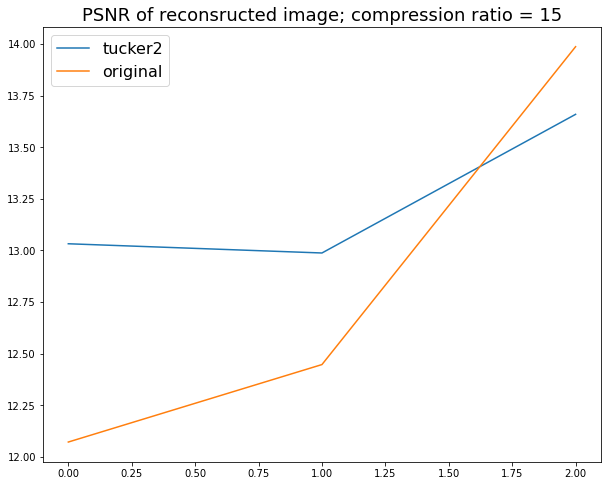

In [79]:
plot_logs(ans_psnrs_gt, 'PSNR of reconsructed image', psnrs_gt)

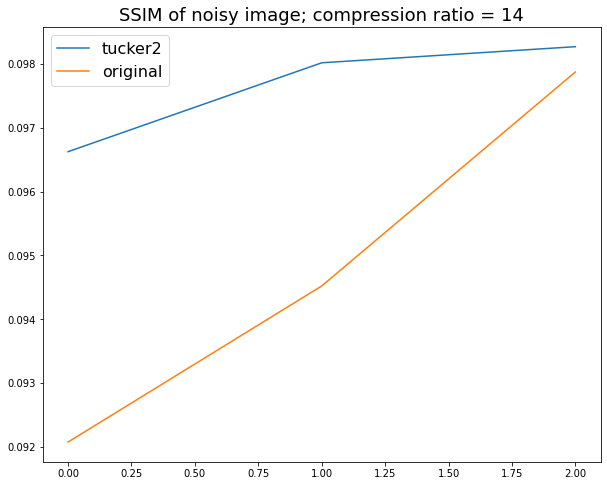

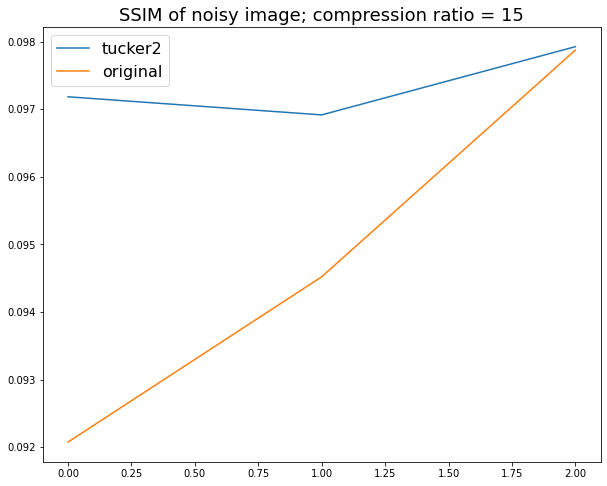

In [80]:
plot_logs(ans_ssims_noisy, 'SSIM of noisy image', ssims_noisy)

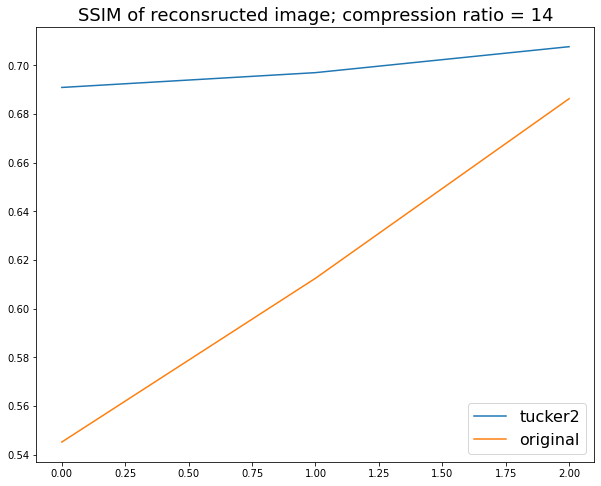

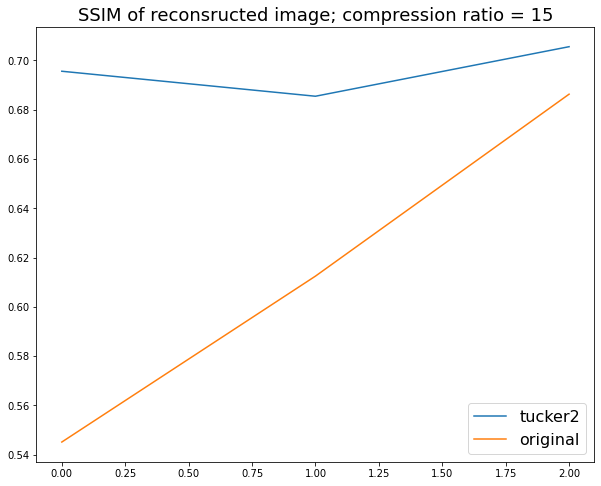

In [81]:
plot_logs(ans_ssims_gt, 'SSIM of reconsructed image', ssims_gt)

In [59]:
import numpy as np
ans_losses[14]['cp4'] = list(np.array(ans_losses[14]['tucker2']) + 1)
ans_losses[15]['cp4'] = list(np.array(ans_losses[15]['tucker2']) + 0.4)
ans_losses

{14: {'tucker2': [0.08237601071596146,
   0.06751762330532074,
   0.06681768596172333],
  'cp4': [1.0823760107159615, 1.0675176233053207, 1.0668176859617233]},
 15: {'tucker2': [0.07782687991857529,
   0.07713538408279419,
   0.06974835693836212],
  'cp4': [0.4778268799185753, 0.4771353840827942, 0.46974835693836214]}}

In [88]:
def plot_logs_comp_ratio(ans_dict, logs_type, original):
    vals = {'tucker2': [], 'cp4': []}
    for k, v in ans_dict.items():
        for mode, values in v.items():
            vals[mode].append(values[-1])
            
    plt.figure(figsize=(10, 8))
    plt.title('The dependence of {} on compression ratio'.format(logs_type), fontsize=18)
    for k, v in vals.items():
        plt.plot(ans_dict.keys(), v, label=k, marker='o')
    plt.axhline(original[-1], ls='--', label='original', c='green')
    plt.legend(fontsize=16)
    plt.show()

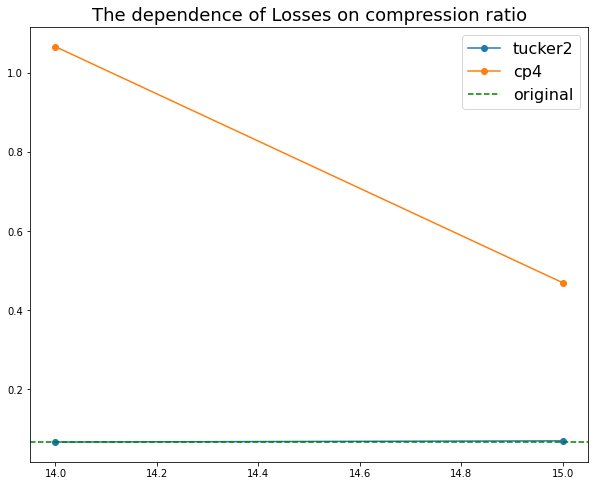

In [89]:
plot_logs_comp_ratio(ans_losses, 'Losses', losses)

ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

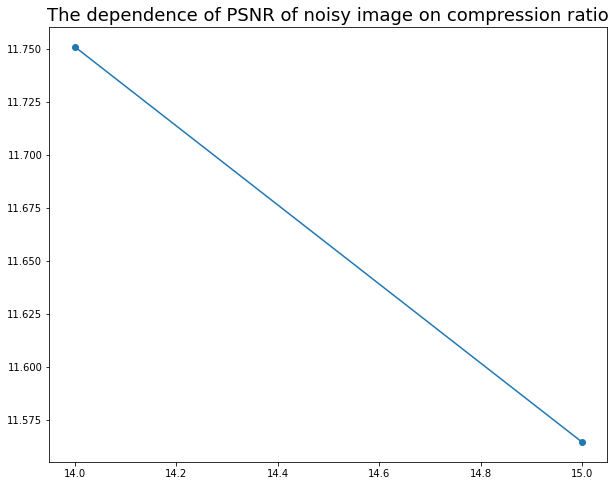

In [68]:
plot_logs_comp_ratio(ans_psnrs_noisy, 'PSNR of noisy image', psnrs_noisy)

ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

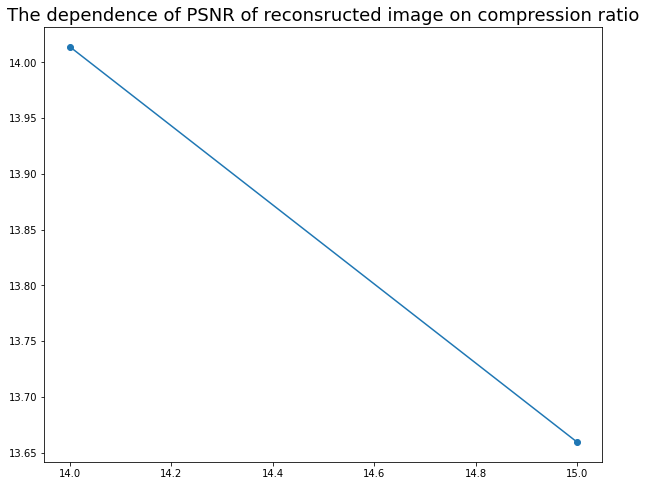

In [69]:
plot_logs_comp_ratio(ans_psnrs_gt, 'PSNR of reconsructed image', psnrs_gt)

In [ ]:
plot_logs_comp_ratio(ans_ssims_noisy, 'SSIM of noisy image', ssims_noisy)

In [ ]:
plot_logs_comp_ratio(ans_ssims_gt, 'SSIM of reconsructed image', ssims_gt)